In [68]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchinfo import summary
import numpy as np

torch.manual_seed(1)
torch.set_default_dtype(torch.float64)

### LSTM Example ###
- torch.nn.LSTM(input_size, hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=None)

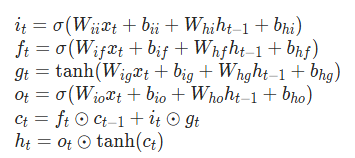
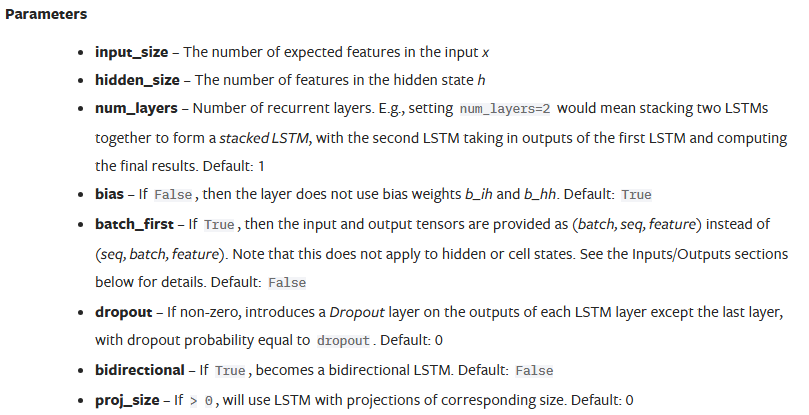
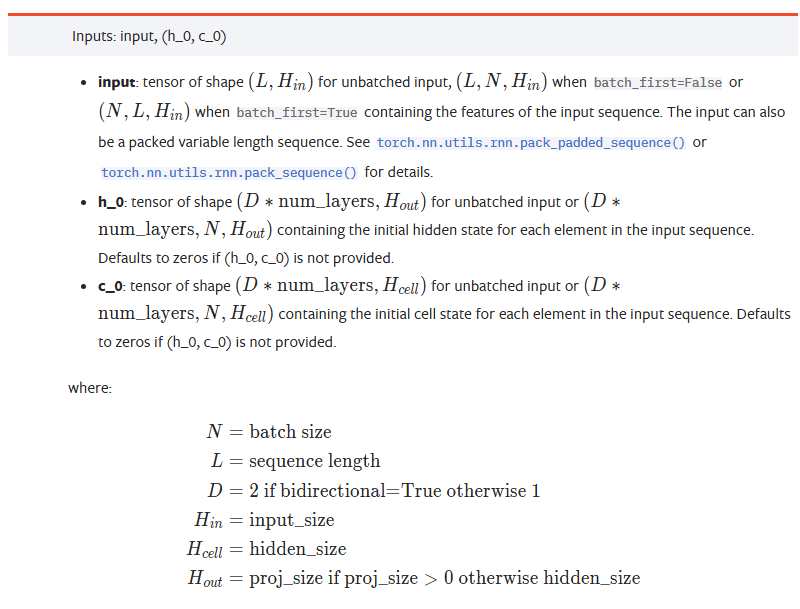
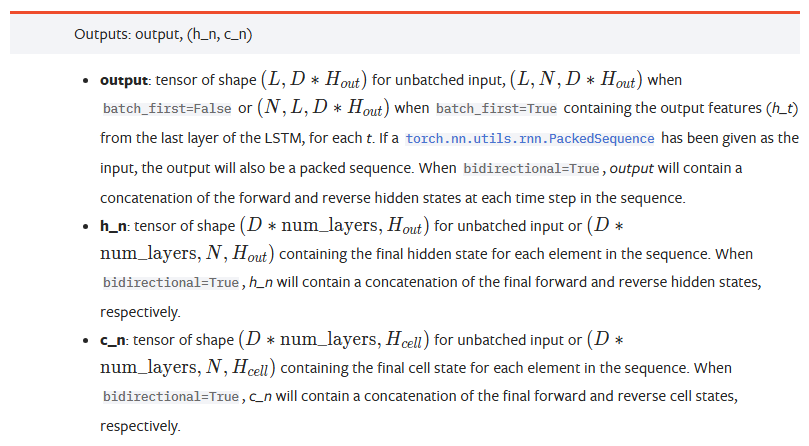
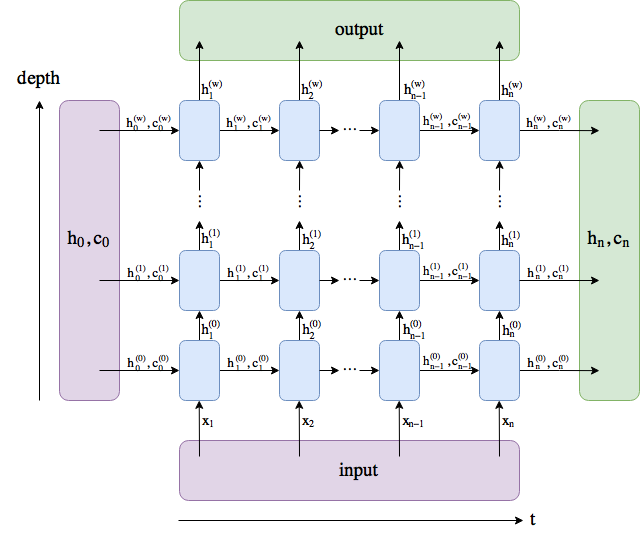

In [11]:
# first way: run each seq step by step

lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state: h_0, c_0.
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))

for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

print(f"out {out.shape}: {out}")
print(f"hidden {[x.shape for x in hidden]}: {hidden}")


out torch.Size([1, 1, 3]): tensor([[[ 0.1796,  0.3257, -0.1486]]], grad_fn=<MkldnnRnnLayerBackward0>)
hidden [torch.Size([1, 1, 3]), torch.Size([1, 1, 3])]: (tensor([[[ 0.1796,  0.3257, -0.1486]]], grad_fn=<StackBackward0>), tensor([[[ 0.3788,  0.7020, -0.3373]]], grad_fn=<StackBackward0>))


In [51]:
# Second way, run entire sequence at once
# NOTICE that Last index of out = first index of hidden
batch_size = 1
lstm = nn.LSTM(3, 4, 1)  # Input dim is 3, output dim is 3
inputs = [torch.randn(batch_size, 3) for _ in range(5)]  # make a sequence of length 5
inputs = torch.cat(inputs).view(len(inputs), batch_size, -1) # shape: (5, 1, 3) seq, batch, feature
hidden = (torch.randn(1, 1, 4), torch.randn(1, 1, 4))  # clean out hidden state
# out, hidden = lstm(inputs, hidden)
print("input shape:", inputs.shape)     # (seqeunce, batch, feature)
out, hidden = lstm(inputs) # out (sequence, batch, hidden), h_n: (layer, batch, hidden), c_n: (layer, batch, hidden)

print(f"out {out.shape}: {out}")
print(f"hidden {[x.shape for x in hidden]}: {hidden}")

input shape: torch.Size([5, 1, 3])
out torch.Size([5, 1, 4]): tensor([[[-0.2065, -0.0717,  0.1091,  0.0849]],

        [[-0.0721, -0.1086,  0.1323,  0.0968]],

        [[-0.0619,  0.0021,  0.2914,  0.1291]],

        [[ 0.0302,  0.0144,  0.4569,  0.1852]],

        [[-0.1003, -0.0716,  0.4733,  0.3357]]],
       grad_fn=<MkldnnRnnLayerBackward0>)
hidden [torch.Size([1, 1, 4]), torch.Size([1, 1, 4])]: (tensor([[[-0.1003, -0.0716,  0.4733,  0.3357]]], grad_fn=<StackBackward0>), tensor([[[-0.1335, -0.1680,  0.7838,  1.0430]]], grad_fn=<StackBackward0>))


### Attention Example ###
- [Attention](https://www.adityaagrawal.net/blog/deep_learning/attention)
- https://www.analyticsvidhya.com/blog/2023/06/time-series-forecasting-using-attention-mechanism/

- https://medium.com/thedeephub/understanding-entity-embedding-in-machine-learning-a-game-changer-for-high-cardinality-faae10b55175
- https://stats.stackexchange.com/questions/330036/understanding-how-to-batch-and-feed-data-into-a-stateful-lstm
- https://medium.com/intel-tech/how-to-apply-transformers-to-time-series-models-spacetimeformer-e452f2825d2e
- https://www.analyticsvidhya.com/blog/2023/06/time-series-forecasting-using-attention-mechanism/
- https://medium.com/@aidant0001/revolutionizing-time-series-prediction-with-lstm-with-the-attention-mechanism-2bd126e9fdf1

In [98]:
# Helper
def save_checkpoint(model, optimizer, save_path, epoch):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, save_path)
    
def load_checkpoint(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    return model, optimizer, epoch

In [128]:
# Plain LSTM
class PlainLSTM(nn.Module):
    def __init__(self, feature_size, hidden_size, output_size = 1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=feature_size, hidden_size=hidden_size, num_layers=1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        return self.fc(h_n[-1]) 
    


In [ ]:
# LSTM with attention


In [ ]:
# LSTM with multi-head attention


In [75]:
# Dataset
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, df, X, y, seq_len=1):
        self.X = df[X].values
        self.y = df[y].values
    
        self.seq_len = seq_len if seq_len != -1 else len(self.X)

    def __len__(self):
        return len(self.X) - self.seq_len + 1
        # return int(np.ceil(len(self.X)/self.seq_len))

    def __getitem__(self, index):
        return self.X[index : index + self.seq_len] , self.y[index + self.seq_len - 1]
        # return (self.X[index * self.seq_len: (index+1) * self.seq_len], self.y[index * self.seq_len: (index+1) * self.seq_len])


In [123]:
# Intialize meta-data
seq_length=5
y_cols =["meantemp_next"]
x_cols = ["humidity", "wind_speed", "meanpressure", "meantemp"]
hidden_size = len(x_cols)

# READ data
df = pd.read_csv("./data/DailyDelhiClimateTrain.csv")
print("Before length", len(df))
df["meantemp_next"] = df["meantemp"].shift(-1)
df.dropna(inplace=True)
print("After length", len(df))
display(df.head())

# Initialize dataset
# train_set, test_set = random_split(ds, [0.8, 0.2])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=99, shuffle=False)

train_ds = TimeseriesDataset(train_df, x_cols, y_cols, seq_length)
test_ds = TimeseriesDataset(test_df, x_cols, y_cols, seq_length)
print("Train Length", len(train_ds))
print("Test Length", len(test_ds))


Before length 1462
After length 1461


,date,meantemp,humidity,wind_speed,meanpressure,meantemp_next
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.400000
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,7.166667
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,8.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,6.000000
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,7.000000


Train Length 1164
Test Length 289


In [131]:
# Test DataLoader
print("length of df", len(df))
ds = TimeseriesDataset(df, ["humidity", "wind_speed", "meanpressure", "meantemp"], ["meantemp_next"], 5)
print("dataset length", len(ds), "of seq length", ds.seq_len)

dl = DataLoader(ds, batch_size=400, shuffle=False)
model = PlainLSTM(feature_size=hidden_size, hidden_size=hidden_size, output_size = 1)
criterion = nn.MSELoss()
for (idx, batch) in enumerate(dl):
    # print(batch[0][:,0,:], batch[0][:,1,:], batch[0][:,2,:])
    model.train()
    X_train = batch[0] 
    n_batch, n_sequence, n_feature = X_train.shape
    X_train =  X_train.view(n_sequence, n_batch, n_feature)     # (seqeunce, batch, feature)
    out = model(X_train)
    loss = criterion(out, batch[1])
    loss.backward()
    
    print(idx, batch[0].shape, batch[1].shape, X_train.shape, out.shape, loss.item(), loss.shape)


length of df 1461
dataset length 1457 of seq length 5
0 torch.Size([400, 5, 4]) torch.Size([400, 1]) torch.Size([5, 400, 4]) torch.Size([400, 1]) torch.Size([])
1 torch.Size([400, 5, 4]) torch.Size([400, 1]) torch.Size([5, 400, 4]) torch.Size([400, 1]) torch.Size([])
2 torch.Size([400, 5, 4]) torch.Size([400, 1]) torch.Size([5, 400, 4]) torch.Size([400, 1]) torch.Size([])
3 torch.Size([257, 5, 4]) torch.Size([257, 1]) torch.Size([5, 257, 4]) torch.Size([257, 1]) torch.Size([])


In [134]:
# Instantiate and train the model
model = PlainLSTM(feature_size=hidden_size, hidden_size=hidden_size, output_size = 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

summary(model, input_size=(100, 1, hidden_size), device="cpu", dtypes=[torch.float64])


Layer (type:depth-idx)                   Output Shape              Param #
PlainLSTM                                [1, 1]                    --
├─LSTM: 1-1                              [100, 1, 4]               160
├─Linear: 1-2                            [1, 1]                    5
Total params: 165
Trainable params: 165
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [138]:


n_epochs = 100
train_dl = DataLoader(ds, batch_size=32, shuffle=False)
test_dl = DataLoader(ds, batch_size=32, shuffle=False)

for epoch in range(n_epochs):
    running_loss = 0.
    last_loss = 0.
    model.train()
    for (idx, (X_train, y_train)) in enumerate(dl):
        # Adjust input shape
        n_batch, n_sequence, n_feature = X_train.shape
        X_train =  X_train.view(n_sequence, n_batch, n_feature)     # (seqeunce, batch, feature)

        # Zero Grad
        optimizer.zero_grad()

        # Train
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    last_loss = running_loss / idx
    print(f"Epoch {epoch}: train loss {last_loss}")
    # Validation
    # if epoch % 1 == 0:
    #     model.eval()
    #     with torch.no_grad():
    #         y_pred = model(X_train)
    #         train_rmse = np.sqrt(criterion(y_pred, y_train))
    #         y_pred = model(X_test)
    #         test_rmse = np.sqrt(criterion(y_pred, y_test))
    # print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train loss 120.71954753664848
Epoch 1: train loss 120.08187055039018
Epoch 2: train loss 119.45083113303731
Epoch 3: train loss 118.82637601163883
Epoch 4: train loss 118.20845220373576
Epoch 5: train loss 117.59700701608274
Epoch 6: train loss 116.99198804339731
Epoch 7: train loss 116.39334316713611
Epoch 8: train loss 115.80102055429768
Epoch 9: train loss 115.21496865625063
Epoch 10: train loss 114.63513620758663
Epoch 11: train loss 114.06147222499698
Epoch 12: train loss 113.49392600617284
Epoch 13: train loss 112.93244712872762
Epoch 14: train loss 112.37698544914127
Epoch 15: train loss 111.82749110172567
Epoch 16: train loss 111.28391449761028
Epoch 17: train loss 110.74620632374781
Epoch 18: train loss 110.21431754193839
Epoch 19: train loss 109.68819938787311
Epoch 20: train loss 109.16780337019456
Epoch 21: train loss 108.65308126957517
Epoch 22: train loss 108.14398513781184
Epoch 23: train loss 107.64046729693696
Epoch 24: train loss 107.14248033834478
Epoch 25: 

In [ ]:
def train_model(model, train_iter, epoch):
    model.train()
    for idx, batch in enumerate(train_iter):
        prediction = model(text)
        loss = loss_fn(prediction, target)
        wandb.log({"Training Loss": loss.item()})
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        wandb.log({"Training Accuracy": acc.item()})
